# RL Lab 7: Dueling DQN

基于Dueling DQN的小丑牌策略算法。

## 简介

为了缓解“致命三要素”的问题，Dueling DQN算法引入了一个新的网络结构，将Q值分解为状态价值函数$V(s)$和优势函数$A(s, a)$的组合，即

$$
Q(s, a) = V(s) + A(s, a) - \frac{1}{|\mathcal {A}|} \sum_{a'} A(s, a')
$$

除此之外，以下的训练技巧同样适用于Dueling DQN：

* 经验回放：将每次的经验$(s, a, r, s')$存储在一个经验池中，随机采样进行训练。
* 目标网络：使用两个网络来计算Q值，一个是当前网络$Q(s, a; \theta)$，另一个是目标网络$Q(s', a'; \theta^{-})$，每次迭代仅更新当前网络参数$\theta$。每隔一段训练步骤将当前网络的参数复制到目标网络中，以保证Q值的稳定性。
* `done`标志：在训练时，使用`done`标志来判断当前状态是否为终止状态。
* $\varepsilon$-greedy策略：在训练时使用$\varepsilon$-greedy策略来选择动作，随着训练的进行，逐渐减小$\varepsilon$的值。

## 目标

* 在`JimboEnvironment`环境中实现Dueling DQN算法。该算法需要包含所有上述训练技巧。

In [1]:
from typing import Tuple, List, Generator

from rl_jimbo_env import JimboState, JimboAction, JimboEnvironment

import torch
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'png'

实现经验回放部分。

In [2]:
class ReplayBuffer():
    def __init__(self, max_size: int = 16384):
        self.max_size = max_size
        self.buffer = []
        self.index = 0

    def add(self, state: JimboState, action: JimboAction, next_state: JimboState, reward: float):
        if len(self.buffer) < self.max_size:
            self.buffer.append((state, action, next_state, reward))
        else:
            self.buffer[self.index] = (state, action, next_state, reward)
        self.index = (self.index + 1) % self.max_size

    def sample(
        self, batch_size: int
    ) -> Tuple[List[JimboState], List[JimboAction], List[JimboState], List[float]]:
        indices = torch.randint(0, len(self.buffer), (batch_size,)).tolist()
        return zip(*[self.buffer[i] for i in indices]) # type: ignore

Q函数需要实现计算$Q(s, a)$，由于动作空间较小，可以直接用线性层将输出转化为各个动作的Q值。状态为5张手牌，可以用transformer对手牌进行建模，之后将输出映射到动作空间上。

In [ ]:
class DuelingQModel(torch.nn.Module):
    def __init__(self, card_embed_dim: int = 16):
        super(DuelingQModel, self).__init__()
        self.trmlayer = torch.nn.TransformerEncoderLayer(
            d_model=card_embed_dim,
            nhead=4,
            dim_feedforward=4 * card_embed_dim,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        # Main model
        self.trm = torch.nn.TransformerEncoder(
            self.trmlayer,
            num_layers=4
        )
        self.fc = torch.nn.Linear(card_embed_dim * 5, 32 + 1)

    def forward(self, hold: torch.Tensor) -> torch.Tensor:
        output = self.fc(self.trm(hold).reshape(hold.shape[0], -1))
        v, a = output[:, 0], output[:, 1:]
        q = v.unsqueeze(1) + a - a.mean(dim=1, keepdim=True)
        return q

DQN需要实现target网络，target网络需要保持为评估模式。

In [ ]:
class JimboDQNAgent(torch.nn.Module):
    def __init__(
        self, card_embed_dim: int = 16, discount: float = 0.9, epsilon: float = 0.1,
        replay_buffer_size: int = 16384
    ):
        super(JimboDQNAgent, self).__init__()
        self.card_embed = torch.nn.Embedding(53, card_embed_dim)
        self.round_embed = torch.nn.Embedding(10, card_embed_dim)
        self.discount = discount
        self.epsilon = epsilon
        self.replay_buffer = ReplayBuffer(replay_buffer_size)

        self.q = DuelingQModel(card_embed_dim)
        self.target_q = DuelingQModel(card_embed_dim)
        self.update_target()
        self.target_q.eval()

        self.device = 'cpu'

    def train(self, mode: bool = True):
        super().train(mode)
        self.target_q.eval()

    def eval(self):
        super().eval()
        self.target_q.eval()

    def update_target(self):
        # Update the target network
        self.target_q.load_state_dict(self.q.state_dict())

    def set_epsilon(self, epsilon: float):
        # Set the epsilon value for the agent
        self.epsilon = epsilon

    def add_to_buffer(
        self, s: JimboState, a: JimboAction, s_prime: JimboState, r: float
    ):
        # Add a transition to the replay buffer
        self.replay_buffer.add(s, a, s_prime, r)

    def set_device(self, device: str):
        self.device = device
        self.to(device)

    def forward(
        self, s: torch.Tensor, s_prime: torch.Tensor,
        done: torch.Tensor, a: torch.Tensor, r: torch.Tensor
    ) -> torch.Tensor:
        batch_size = a.shape[0]
        q_sa = self.q(s)[torch.arange(batch_size), a]
        q_s_prime_a_prime = self.target_q(s_prime).max(dim=1)[0].detach()
        return torch.nn.functional.mse_loss(
            q_sa, r / 100 + self.discount * q_s_prime_a_prime * (1 - done)
        )

    def q_loss(self, batch_size: int = 64) -> torch.Tensor:
        # Sample a batch from the replay buffer
        s, a, s_prime, r = self.replay_buffer.sample(batch_size)
        s_tensor = self.states_to_tensor(s)
        s_prime_tensor = self.states_to_tensor(s_prime)
        done = torch.tensor(
            [state.end for state in s_prime],
            dtype=torch.float, device=self.device
        )
        a_tensor = self.actions_to_tensor(a)
        r_tensor = torch.tensor(r, dtype=torch.float, device=self.device)
        return self(s_tensor, s_prime_tensor, done, a_tensor, r_tensor)

    def policy(
        self, states: List[JimboState], epsilon: float | None = None
    ) -> List[JimboAction]:
        # Epsilon-greedy policy
        if epsilon is None:
            epsilon = self.epsilon
        greedy = self.q(self.states_to_tensor(states)).argmax(dim=1)
        random = torch.randint(0, 32, size=greedy.shape, device=self.device)
        action = torch.where(
            torch.rand(greedy.shape, device=self.device) < epsilon,
            random, greedy
        )
        return [JimboAction.from_index(row) for row in action.tolist()]

    def action_to_tensor(self, action: JimboAction) -> torch.Tensor:
        # Convert the action to a tensor
        return torch.tensor(
            action.index, dtype=torch.long, device='cpu'
        )

    def actions_to_tensor(self, actions: List[JimboAction]) -> torch.Tensor:
        # Convert the actions to a tensor
        # actions: (batch_size, card * 5)
        return torch.stack([
            self.action_to_tensor(action) for action in actions
        ], dim=0).to(self.device)

    def state_to_tensor(
        self, states: JimboState
    ) -> torch.Tensor:
        # Convert the state to a tensor
        # state: {hold: card * 5, discard: card * 0-n, round: int}
        hold_idx_tensor = torch.tensor([
            card.index for card in states.hold
        ], dtype=torch.long, device=self.device)
        return self.card_embed(hold_idx_tensor)

    def states_to_tensor(self, states: List[JimboState]) -> torch.Tensor:
        # Convert the states to a tensor
        # states: {hold: card * 5, discard: card * 0-n, round: int}
        hold_idx_tensor = torch.tensor([
            [card.index for card in state.hold] for state in states
        ], dtype=torch.long, device=self.device)
        return self.card_embed(hold_idx_tensor)

训练过程中使用一组固定的初始状态用于评估训练效果。

In [5]:
env = JimboEnvironment()
agent = JimboDQNAgent(64, 0.9, 0.9)
agent.set_device('mps')

eval_states = [env.starting_state for _ in range(128)]

def simulate(
    env: JimboEnvironment, agent: JimboDQNAgent, n: int = 512,
    states: List[JimboState] | None = None
) -> float:
    # Simulate the environment with the agent
    agent.eval()
    if states is None:
        states = [env.starting_state for _ in range(n)]
    states = states.copy()
    assert all(state.round == 0 for state in states), "states must be in round 0"
    while True:
        assert states is not None
        actions = agent.policy(states, 0) # type: ignore
        states, rewards = zip(*(
            env.state_transition(state, action)
            for state, action in zip(states, actions)
        ))
        assert states is not None
        if any(state.round >= 2 for state in states):
            break
    agent.train()
    return sum(rewards) / len(rewards)


simulate(env, agent, states=eval_states)

62.2421875

In [6]:
def train(
    env: JimboEnvironment, agent: JimboDQNAgent, *,
    batch_size: int = 128, lr: float = 1e-3,
    eval_steps: int = 10, eval_states: List[JimboState] | None = None,
    update_steps: int = 10,
    epsilon_decay: float = 0.99, min_epsilon: float = 0.005,
    max_steps: int = 10000
):
    states = []
    optimizer = torch.optim.Adam(agent.q.parameters(), lr=lr)
    for step in range(max_steps):
        if not states:
            states = [env.starting_state for _ in range(batch_size // 2)]
        actions = agent.policy(states)
        next_states = []
        for state, action in zip(states, actions):
            next_state, reward = env.state_transition(state, action)
            agent.add_to_buffer(state, action, next_state, reward)
            next_states.append(next_state)

        q_loss = agent.q_loss(batch_size * 2)
        loss = q_loss.item()
        optimizer.zero_grad()
        q_loss.backward()
        optimizer.step()

        if step % eval_steps == 0:
            eval_reward = simulate(env, agent, states=eval_states)
        else:
            eval_reward = None
        if step % update_steps == 0:
            agent.update_target()
        if step % epsilon_decay == 0:
            agent.set_epsilon(max(min_epsilon, agent.epsilon * epsilon_decay))

        yield loss, eval_reward

        states = [state for state in next_states if state.round < 2]
        states.extend([
            env.starting_state for _ in range(batch_size // 2)
        ])

训练模型并绘制Q损失和平均奖励曲线。

In [7]:
from IPython.display import clear_output
import math

def append_ma(
    data: List[float], new_data: float, alpha: float = 0.99
):
    if not data:
        data.append(new_data)
    else:
        data.append(data[-1] * alpha + (1 - alpha) * new_data)

def plot_train(
    train_gen: Generator[Tuple[float, float | None], None, None],
    plot_steps: int = 100, max_steps: int = 10000, alpha: float = 0.99
):
    losses, eval_rewards = [], []
    plt.ion()
    for step, (loss, eval_reward) in enumerate(train_gen):
        if step >= max_steps:
            break
        append_ma(losses, loss, alpha)
        if eval_reward is not None:
            append_ma(eval_rewards, eval_reward, alpha)
        if step % plot_steps == 0:
            clear_output(wait=True)
            fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, dpi=300)

            xlim_step = max_steps / 10
            limit = math.ceil(len(losses) / xlim_step) * xlim_step

            ax0.clear()
            ax0.plot(losses)
            ax0.set_title("Q Loss")
            ax0.set_xlabel("Step")
            ax0.set_ylabel("Loss")
            ax0.set_xlim(0, limit)
            ax0.grid()

            len_ratio = len(losses) / len(eval_rewards)
            ax1.clear()
            ax1.plot(
                [i * len_ratio for i, _ in enumerate(eval_rewards)],
                eval_rewards
            )
            ax1.set_title("Episodic Rewards")
            ax1.set_xlabel("Step")
            ax1.set_ylabel("Reward")
            ax1.set_xlim(0, limit)
            ax1.grid()

            plt.draw()
            plt.pause(0.01)

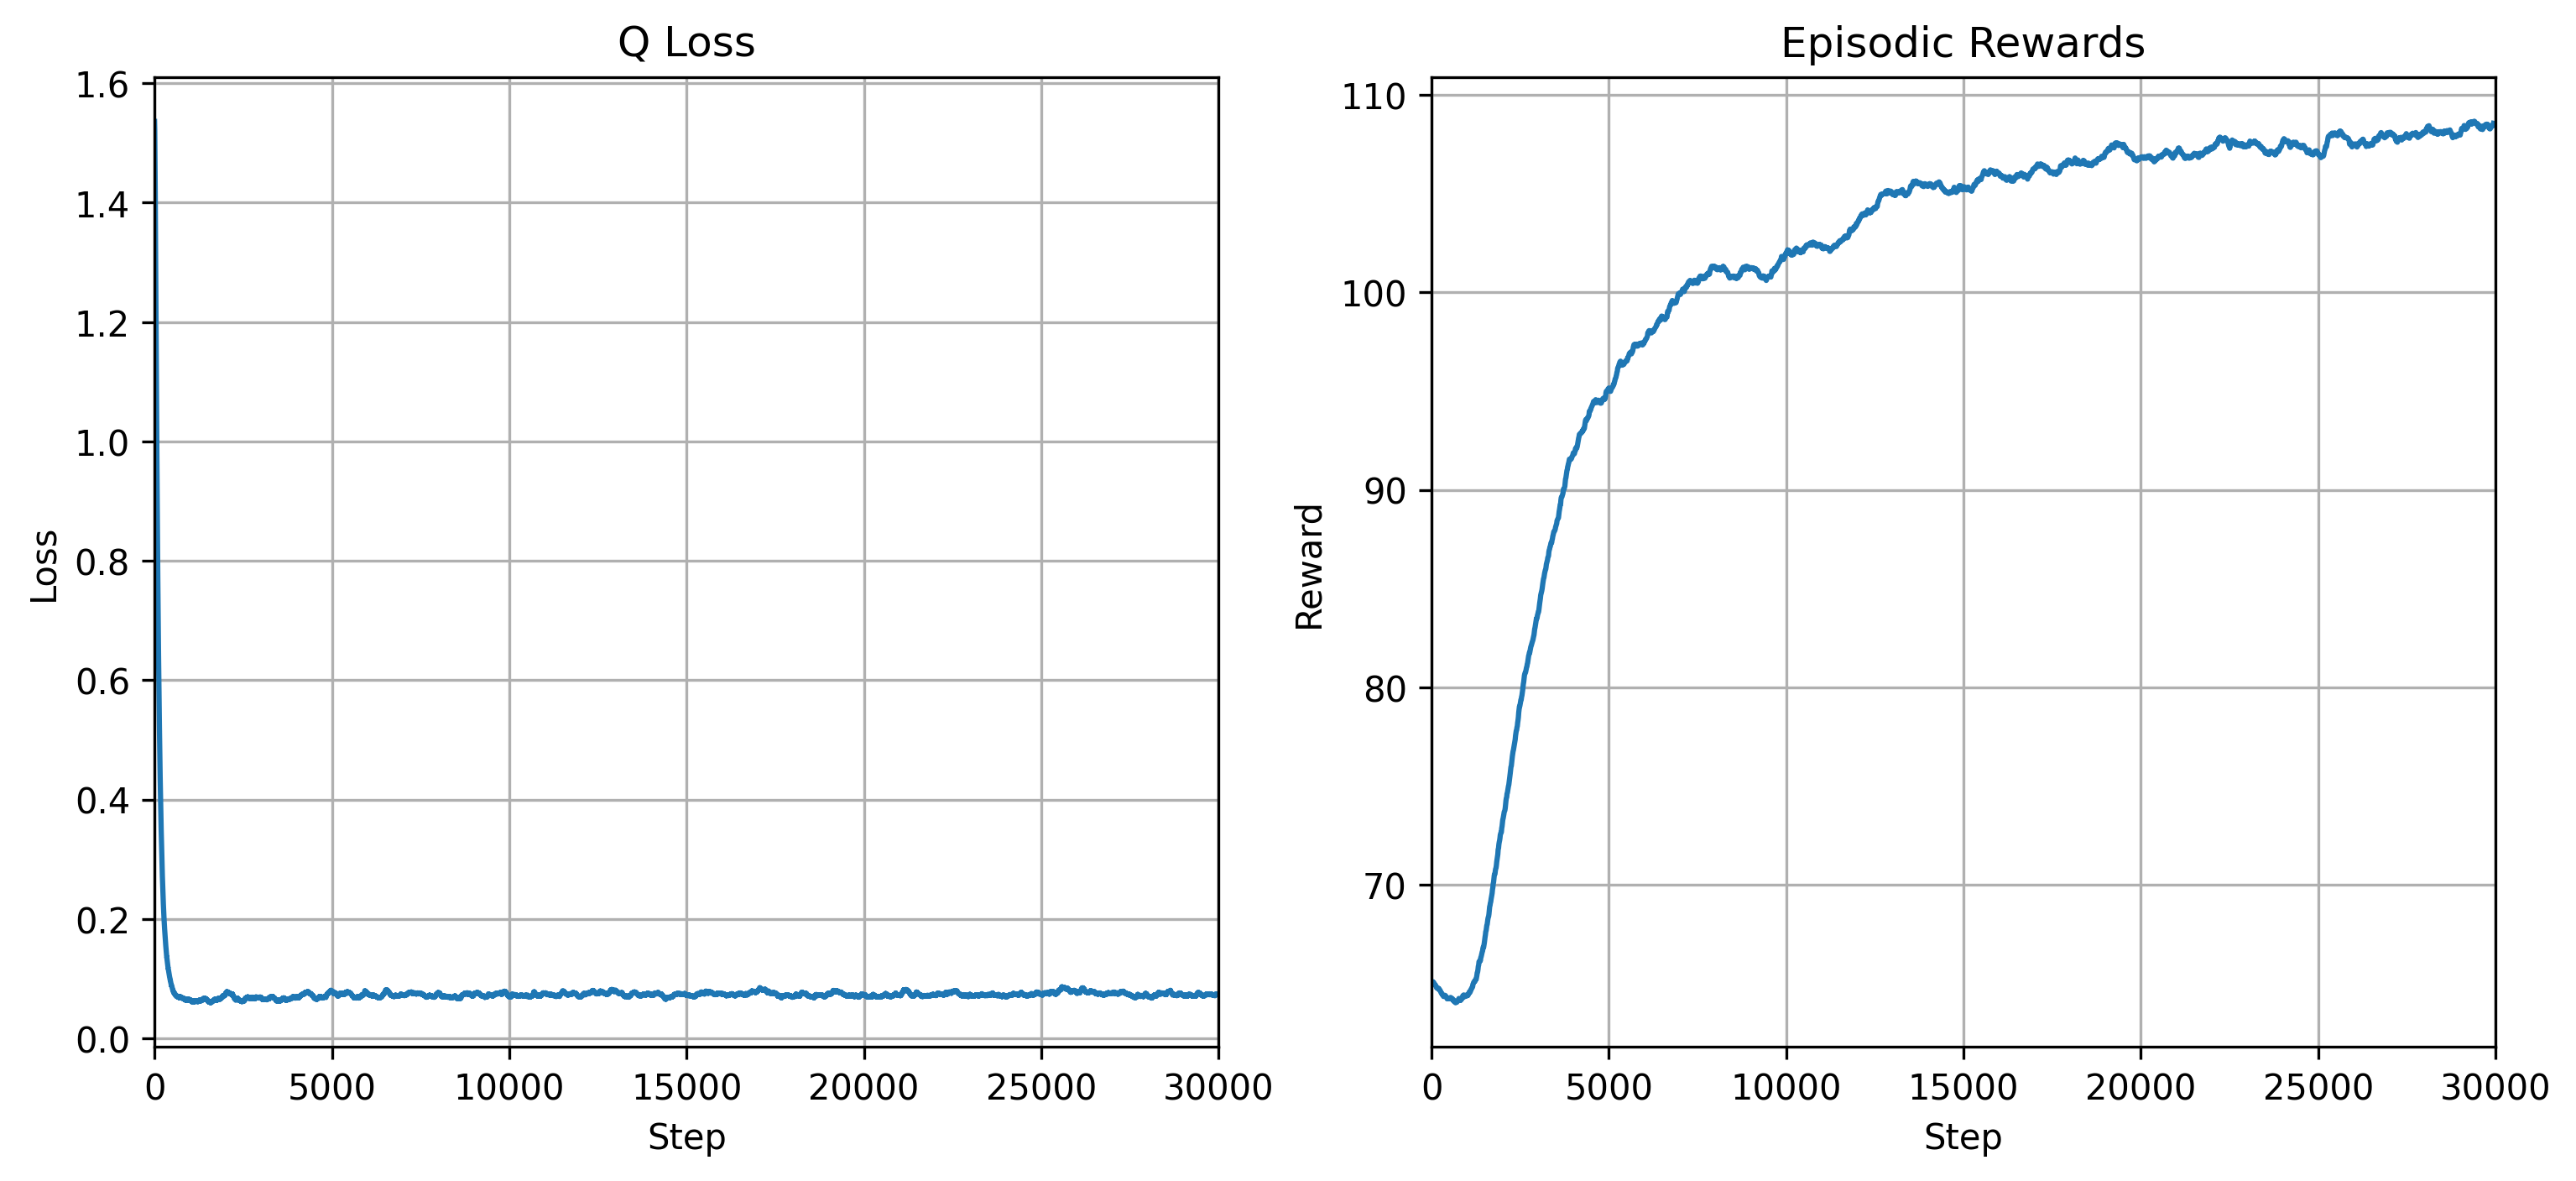

In [8]:
train_args = {
    'batch_size': 128,
    'lr': 1e-3,
    'eval_steps': 10,
    'update_steps': 10,
    'epsilon_decay': 0.99,
    'min_epsilon': 0.005,
    'max_steps': 30000
}

train_gen = train(env, agent, eval_states=eval_states, **train_args)
plot_train(train_gen, plot_steps=50, max_steps=30000, alpha=0.99)

训练结束后对比训练前后智能体的表现，并且展示一组智能体的策略。

In [9]:
simulate(env, agent, states=eval_states)

98.6015625

In [10]:
import random

states_eval = eval_states.copy()
agent.eval()
idx = random.randint(0, len(states_eval) - 1)

while True:
    print(states_eval[idx])
    actions = agent.policy(states_eval, 0)  # type: ignore
    print(actions[idx])
    states_eval, rewards = zip(*(
        env.state_transition(state, action)
        for state, action in zip(states_eval, actions)
    ))
    print(states_eval[idx])
    if any(state.round >= 2 for state in states_eval):
        break
print(states_eval[idx].ratio)
print(rewards[idx])

A♥ J♠ Q♣ 5♥ 8♣
JimboAction(discard=(False, False, False, True, True))
A♥ J♠ Q♣ K♦ 5♠
A♥ J♠ Q♣ K♦ 5♠
JimboAction(discard=(True, True, True, False, True))
K♠ 2♣ A♦ K♦ 4♠
2
86
